<a href="https://colab.research.google.com/github/tumanov-a/imdb_sentiment_analys/blob/main/imdb_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, plot_roc_curve
from scipy import sparse

%matplotlib inline

In [2]:
! pip install vaderSentiment

     |████████████████████████████████| 133kB 5.6MB/s 


In [9]:
reviews = pd.read_csv('IMDB Dataset.csv.zip', compression='zip')

In [7]:
reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


Дополнительно добавим столбцы со значениеми сентимента с помощью библиотеки vaderSentiment:

In [6]:
def sentiment_analyzer(text):
  analyzer = SentimentIntensityAnalyzer()
  sentiment_scores = analyzer.polarity_scores(text)
  return sentiment_scores

In [7]:
reviews['review'] = reviews['review'].apply(sentiment_analyzer)

In [8]:
reviews_scores_sentiment = reviews.review.apply(pd.Series)

In [10]:
reviews = pd.concat([reviews, reviews_scores_sentiment], axis=1)

Уберем дубли:

In [11]:
reviews.nunique()

review       49582
sentiment        2
neg            371
neu            495
pos            453
compound     11271
dtype: int64

In [12]:
reviews.drop_duplicates(['review'], inplace=True)

Почистим текст от html-тегов:

In [70]:
reviews.review.tolist()[:50]

["One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.I would say the main appeal of the show is due to the fact that it goes where other shows w

In [13]:
def replace_(fragment):
  fragment = re.sub('<br />', '', fragment)
  return fragment

In [14]:
reviews['review'] = reviews['review'].apply(replace_)

In [15]:
reviews['sentiment'] = reviews['sentiment'].map({'positive': 1, 'negative': 0})

In [16]:
reviews

,review,sentiment,neg,neu,pos,compound
0,One of the other reviewers has mentioned that ...,1,0.179,0.756,0.064,-0.9916
1,A wonderful little production. The filming tec...,1,0.052,0.773,0.176,0.9670
2,I thought this was a wonderful way to spend ti...,1,0.114,0.688,0.198,0.9519
3,Basically there's a family where a little boy ...,0,0.125,0.816,0.059,-0.9213
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,0.050,0.806,0.144,0.9744
...,...,...,...,...,...,...
49995,I thought this movie did a down right good job...,1,0.045,0.765,0.189,0.9886
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0,0.160,0.730,0.110,-0.6837
49997,I am a Catholic taught in parochial elementary...,0,0.181,0.704,0.115,-0.9734
49998,I'm going to have to disagree with the previou...,0,0.116,0.804,0.080,-0.8657


Судя по всему признаки, полученные с помощью sentiment_analyzer, будут достаточно хорошими, т.к. явно разделяются при различном таргете:

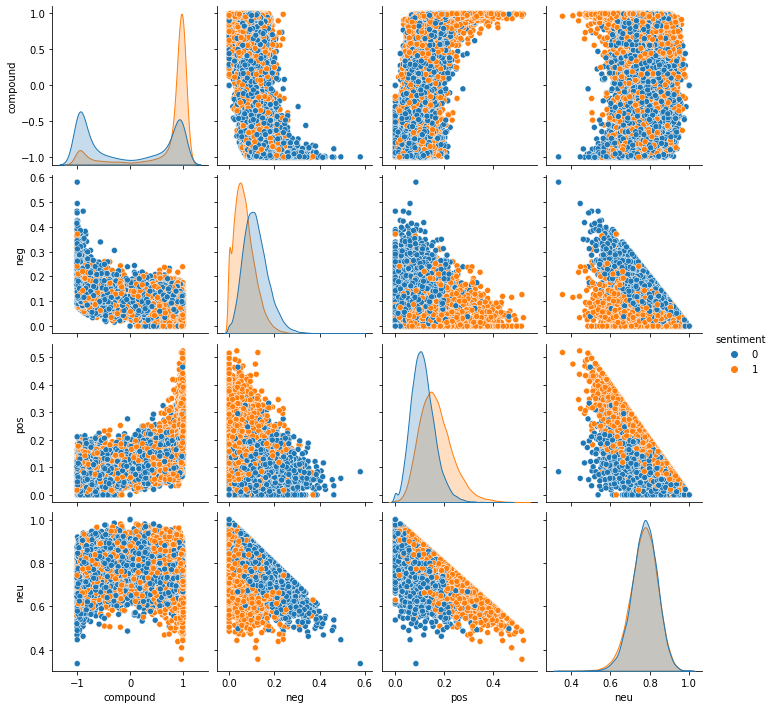

In [ ]:
sns.pairplot(reviews[['compound', 'neg', 'pos', 'neu', 'sentiment']], hue='sentiment')

In [17]:
y = np.array(reviews.pop('sentiment'))
x = np.array(reviews)

Дисбаланс классов отсутствует:

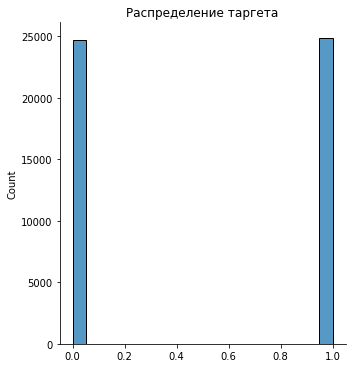

In [28]:
sns.displot(y)
plt.title('Распределение таргета')
plt.show()

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=2)

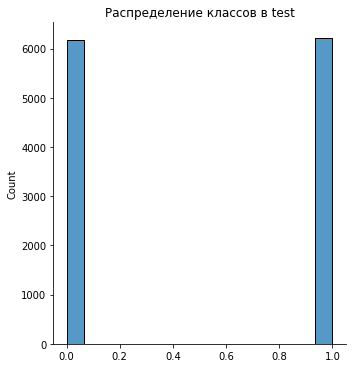

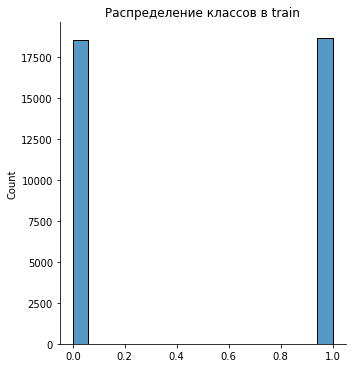

In [39]:
sns.displot(y_test)
plt.title('Распределение классов в test')

sns.displot(y_train)
plt.title('Распределение классов в train')
plt.show()

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1,2))
x_train_text = vectorizer.fit_transform(x_train[:, 0])
x_test_text = vectorizer.transform(x_test[:, 0])

In [29]:
len(vectorizer.get_feature_names())

2031577

In [38]:
X_train = sparse.hstack([x_train_text, x_train[:, [1,2,4]].astype('float64')])
X_test = sparse.hstack([x_test_text, x_test[:, [1,2,4]].astype('float64')])

Определим функцию для кросс-валидации, построения графика и построения модели по лучшему коэффиенту регуляризации на основе кросс-валидации. Пропишем атрибут random_state для воспроизводимости результатов.

In [22]:
reg = [0.001, 0.01, 0.1, 1, 10, 100]

In [23]:
def train_and_plot(X_tr, X_ts, y_tr, y_ts):
  cvs = []

  for val in reg:
    linsvc = LinearSVC(C=val, random_state=42)
    cvs.append(cross_val_score(linsvc, X_tr, y_tr, cv=3).mean())
    
  best_reg = reg[np.array(cvs).argmax()]

  plt.figure(figsize=(10,8))
  plt.plot(list(range(len(cvs))), cvs)
  plt.title('Average cross_val_score with different regularization')
  plt.xticks(ticks=range(len(reg)), labels=reg)
  plt.show()

  linsvc = LinearSVC(C=best_reg, random_state=42)
  linsvc.fit(X_tr, y_tr)
  lin_score = linsvc.score(X_ts, y_ts)
  print(f'Score with best regularization = {lin_score}')

Сначала ngram_range=(1,1) в count_vectorization + все числовые признаки из sentiment_analys:


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


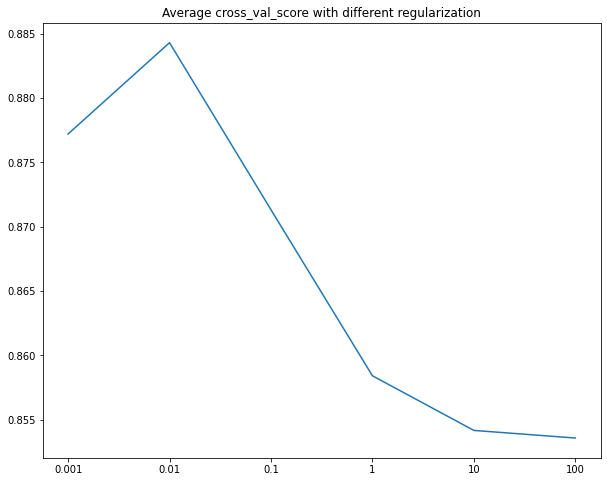

Score with best regularization = 0.8874636979670861


In [24]:
train_and_plot(X_train, X_test, y_train, y_test)

ngram_range=(1,2) в count_vectorization + все числовые признаки из sentiment_analys:


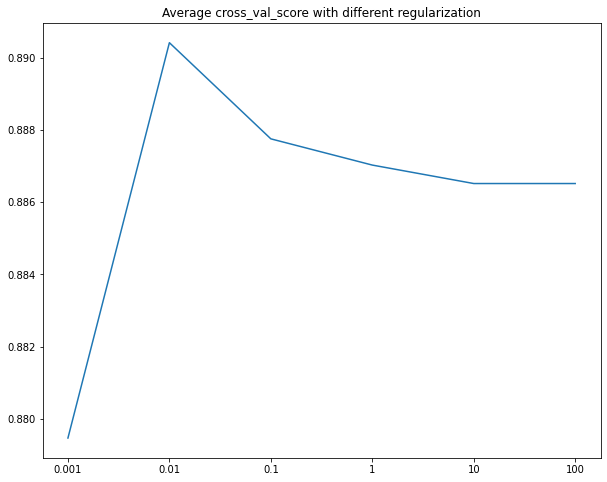

Score with best regularization = 0.8941594062600839


In [27]:
train_and_plot(X_train, X_test, y_train, y_test)

ngram_range=(1,2) со всеми стоп-словами в count_vectorization + все числовые признаки из sentiment_analys:

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


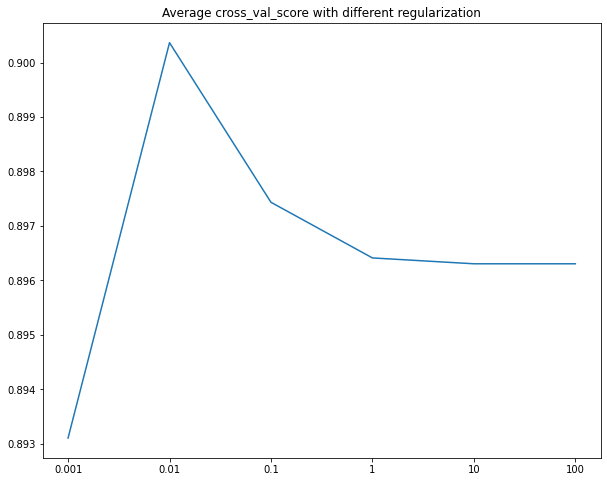

Score with best regularization = 0.9077121652145853


In [31]:
train_and_plot(X_train, X_test, y_train, y_test)

ngram_range=(1,2) со всеми стоп-словами в count_vectorization +  числовые признаки neg, pos, compound из sentiment_analys:

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


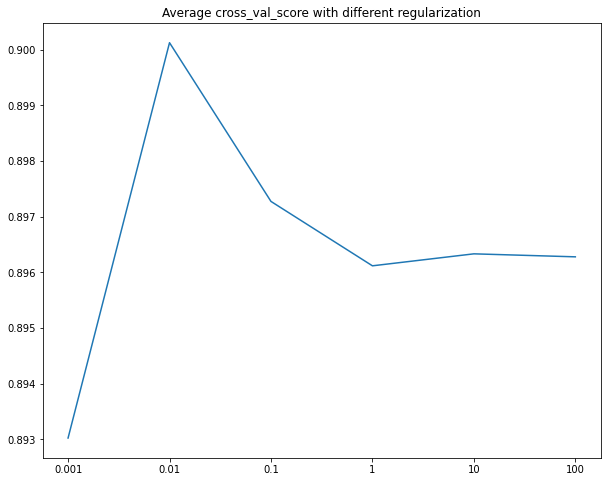

Score with best regularization = 0.9074701516618264


In [39]:
train_and_plot(X_train, X_test, y_train, y_test)

Результат без дополнительных столбцов sentiment analys является лучшим:

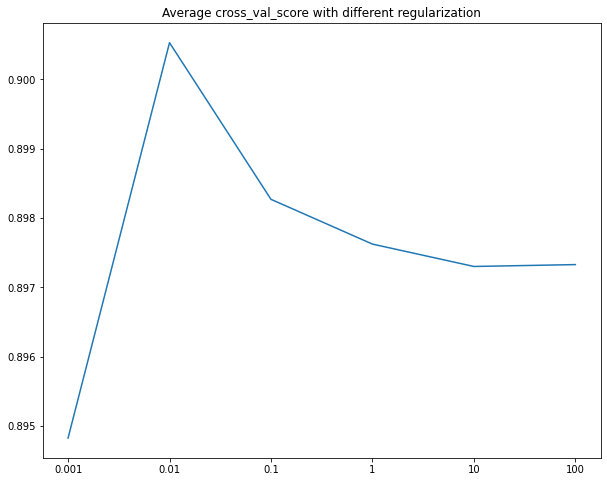

Score with best regularization = 0.9088415617941271


In [40]:
train_and_plot(x_train_text, x_test_text, y_train, y_test)

In [42]:
linsvc = LinearSVC(C=0.01, random_state=42)
linsvc.fit(x_train_text, y_train)
linsvc.score(x_test_text, y_test)
y_pred = linsvc()

0.9088415617941271

In [45]:
y_pred = linsvc.predict(x_test_text)

In [46]:
print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.92      0.90      0.91      6176
    positive       0.90      0.92      0.91      6220

    accuracy                           0.91     12396
   macro avg       0.91      0.91      0.91     12396
weighted avg       0.91      0.91      0.91     12396



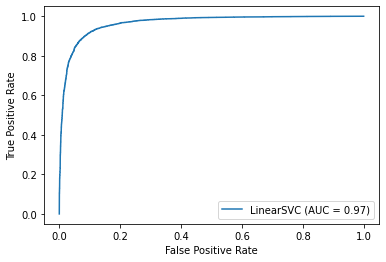

In [68]:
plot_roc_curve(linsvc, x_test_text, y_test)